In [19]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

In [20]:
print(torch.__version__)
# Only works with GPU due to input_size
device = "cpu"
input_window = 7 # 7 days in week
output_window = 1 # predict for the next day
BATCH_SIZE = 100
print(device)

2.2.2
cpu


In [21]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [22]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [23]:
# create batches from input and target sequence 
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [24]:
composite_df = pd.read_csv("composite_stocks.csv")
DJI_close = composite_df['DJI']
DJI_close.size

5785

In [25]:
DJI_log_prices = np.diff(np.log(DJI_close))
DJI_log_prices_cumsum = DJI_log_prices.cumsum()
DJI_close

0       10646.150391
1       10945.750000
2       10912.410156
3       10662.009766
4       10621.349609
            ...     
5780    37385.968750
5781    37545.328125
5782    37656.519531
5783    37710.101562
5784    37689.539062
Name: DJI, Length: 5785, dtype: float64

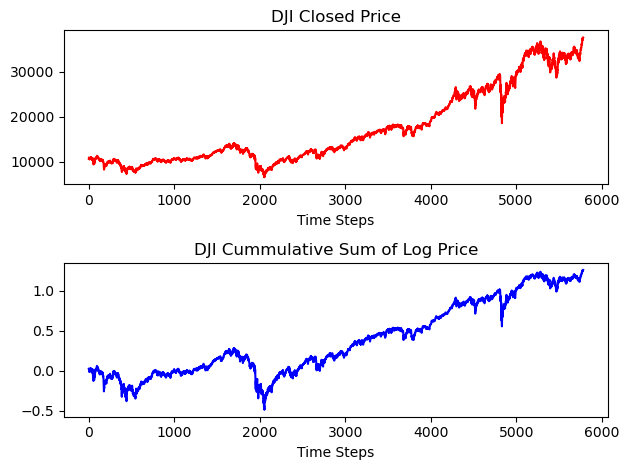

In [26]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(DJI_close, color='red')
ax1[0].set_title('DJI Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(DJI_log_prices_cumsum, color='blue')
ax1[1].set_title('DJI Cummulative Sum of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [27]:
train_data, test_data = get_data(DJI_log_prices, 0.7) # 70-30 split

In [28]:
from lstm import LSTMModel
model = LSTMModel().to(device)
criterion = nn.MSELoss()
EPOCHS = 1000
learning_rate = 0.00005
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [29]:
def train(train_data):
  model.train()
  total_loss = 0
  start_time = time.time()

  for batch, i in enumerate(range(0, len(train_data) - 1, BATCH_SIZE)):
    data, targets = get_batch(train_data, i, BATCH_SIZE)
    # print(f"Input data shape: {data.shape}")  # Add this line
    # print(f"Targets shape: {targets.shape}")  # Add this line
    data, targets = get_batch(train_data, i, BATCH_SIZE)
    # apply gradient descent
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, targets)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.7)
    optimizer.step()

    total_loss = total_loss + loss.item()
    # log_interval = int(len(train_data) / BATCH_SIZE / 5)
    log_interval = max(int(len(train_data) / BATCH_SIZE / 5), 1)
    if batch % log_interval == 0 and batch > 0:
        cur_loss = total_loss / log_interval
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5d}/{:5d} batches | '
              'lr {:02.10f} | {:5.2f} ms | '
              'loss {:5.7f}'.format(
                epoch, batch, len(train_data) // BATCH_SIZE, scheduler.get_lr()[0],
                elapsed * 1000 / log_interval,
                cur_loss))
        total_loss = 0
        start_time = time.time()


In [30]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [31]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [32]:
for epoch in range(1, EPOCHS+1):
  epoch_start_time = time.time()
  train(train_data)

  if epoch % EPOCHS == 0:
    val_loss = evaluate(model, test_data)
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                (time.time() - epoch_start_time),
                                                                                val_loss))
    print('-' * 80)

  else:
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
    print('-' * 80)

  scheduler.step()

torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])


c:\Users\yzche\anaconda3\envs\cuda_venv\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     8/   40 batches | lr 0.0000500000 | 59.94 ms | loss 0.0837845
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
| epoch   1 |    16/   40 batches | lr 0.0000500000 | 50.13 ms | loss 0.0649323
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
| epoch   1 |    24/   40 batches | lr 0.0000500000 | 53.63 ms | loss 0.1038455
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
| epoch   1 |    32/   40 batches | lr 0.0000500000 | 50.17 ms | loss 0.2693005
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Size([7, 100, 1])
torch.Si

In [33]:
predicted_seq, real_seq = predict(model, test_data)

torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size([7, 1, 1])
torch.Size

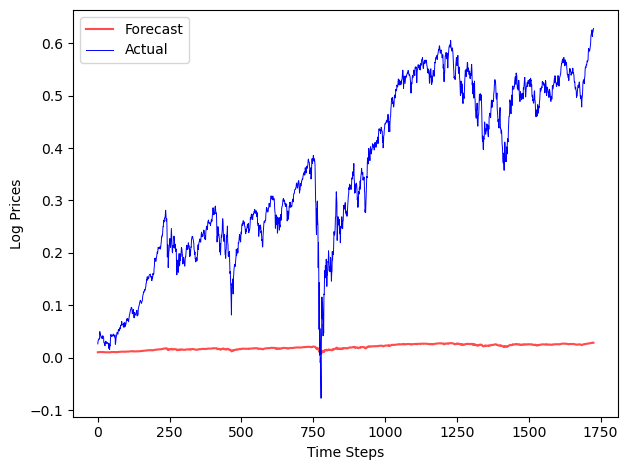

In [34]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='red', alpha=0.7)
ax2.plot(real_seq, color='blue', linewidth=0.7)
ax2.legend(['Forecast', 'Actual'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()